In [1]:
import os
import sys
import pickle
import jax
import torch
import numpy as np
import pandas as pd
import scipy.stats as ss
from classy import Class
from typing import Tuple, List, Dict, Union
import matplotlib.pylab as plt
from ml_collections.config_dict import ConfigDict
from torchemu.gaussianprocess import GaussianProcess
from jax_cosmo.utils import load_pkl, save_pkl
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import jax.numpy as jnp
from jax import jit

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
def get_config(experiment) -> ConfigDict:
    """Generates and returns a configuration dictionary for the emulator.

    This function sets up various configuration parameters for the emulator,
    including neutrino settings, CLASS settings, priors, and emulator settings.

    Returns:
        ConfigDict: A configuration dictionary containing the following keys:
            - neutrino: Neutrino settings.
            - classy: CLASS settings.
            - priors: Prior distributions for various parameters.
            - emu: Emulator settings.
    """
    config = ConfigDict()
    config.logname = "cmb_power_spectra"
    config.experiment = experiment

    # cosmological parameters
    config.cosmo = cosmo = ConfigDict()
    cosmo.names = ["sigma8", "Omega_cdm", "Omega_b", "h", "n_s"]

    # neutrino settings
    config.neutrino = neutrino = ConfigDict()
    neutrino.N_ncdm = 1.0
    neutrino.deg_ncdm = 3.0
    neutrino.T_ncdm = 0.71611
    neutrino.N_ur = 0.00641
    neutrino.fixed_nm = 0.06

    # CLASS settings
    config.classy = classy = ConfigDict()
    classy.output = "tCl,pCl,lCl,mPk"
    classy.Omega_k = 0.0
    classy.k_max_pk = 50

    # priors
    config.priors = {
        "sigma8": {"distribution": "uniform", "loc": 0.7, "scale": 0.2, "fiducial": 0.8},
        "Omega_cdm": {"distribution": "uniform", "loc": 0.20, "scale": 0.15, "fiducial": 0.2},
        "Omega_b": {"distribution": "uniform", "loc": 0.04, "scale": 0.02, "fiducial": 0.045},
        "h": {"distribution": "uniform", "loc": 0.62, "scale": 0.12, "fiducial": 0.68},
        "n_s": {"distribution": "uniform", "loc": 0.90, "scale": 0.2, "fiducial": 1.0},
    }

    # emulator settings
    config.emu = emu = ConfigDict()
    emu.nlhs = 1000
    emu.jitter = 1e-10
    emu.lr = 0.01
    emu.nrestart = 1
    emu.niter = 500

    return config

def class_args(config: ConfigDict) -> Dict:
    """Generates CLASS arguments to be passed to classy to compute the different quantities.
    Args:
        config (ConfigDict): A configuration file containing the parameters.
    Returns:
        dict: A dictionary to input to class
    """
    dictionary = dict()
    dictionary['output'] = config.classy.output
    dictionary['P_k_max_1/Mpc'] = config.classy.k_max_pk
    dictionary['Omega_k'] = config.classy.Omega_k
    return dictionary

def neutrino_args(config: ConfigDict) -> Dict:
    """Generates a dictionary for the neutrino settings.
    Args:
        config (ConfigDict): The main configuration file
    Returns:
        dict: A dictionary with the neutrino parameters.
    """
    dictionary = dict()
    dictionary['N_ncdm'] = config.neutrino.N_ncdm
    dictionary['deg_ncdm'] = config.neutrino.deg_ncdm
    dictionary['T_ncdm'] = config.neutrino.T_ncdm
    dictionary['N_ur'] = config.neutrino.N_ur
    dictionary['m_ncdm'] = config.neutrino.fixed_nm / config.neutrino.deg_ncdm
    return dictionary

def delete_module(class_module: Class):
    """Deletes the module to prevent memory overflow.
    Args:
        module (Class): A CLASS module
    """
    class_module.struct_cleanup()

    class_module.empty()

    del class_module

def class_compute(config: ConfigDict, cosmology: Dict) -> Class:
    """Pre-computes the quantities in CLASS.
    Args:
        config (ConfigDict): The main configuration file for running Class
        cosmology (dict): A dictionary with the cosmological parameters
    Returns:
        Class: A CLASS module
    """
    # generates the dictionaries to input to Class
    arg_class = class_args(config)
    arg_neutrino = neutrino_args(config)

    # Run Class
    class_module = Class()
    class_module.set(arg_class)
    class_module.set(arg_neutrino)
    class_module.set(cosmology)
    class_module.compute()

    return class_module

def calculate_cmb_cls_class(cosmology: Dict, cfg: ConfigDict, ellmax: int = 2500) -> np.ndarray:
    """Calculate the linear matter power spectrum using CLASS.

    Args:
        cosmology (Dict): A dictionary containing cosmological parameters.
        cfg (ConfigDict): A configuration dictionary containing CLASS settings.

    Returns:
        np.ndarray: An array of linear matter power spectrum values.

    """
    cmodule = class_compute(cfg, cosmology)
    cells = cmodule.raw_cl(ellmax)
    factor = 2.7255e6 ** 2 * cells['ell'] * (cells['ell'] + 1) / (2 * np.pi)
    cls_tt = cells['tt'] * factor
    cls_ee = cells['ee'] * factor
    cls_te = cells['te'] * factor
    delete_module(cmodule)
    return cells['ell'][2:], cls_tt[2:], cls_ee[2:], cls_te[2:]

def generate_cosmo_priors(cfg: ConfigDict) -> Dict:
    """Generate cosmological priors based on the configuration settings.

    Args:
        cfg (ConfigDict): A configuration dictionary containing cosmological parameter names and their prior distributions.

    Returns:
        Dict: A dictionary where keys are cosmological parameter names and values are their corresponding prior distributions.
    """
    dictionary = dict()
    for name in cfg.cosmo.names:
        param = cfg.priors[name]
        specs = (param.loc, param.scale)
        dictionary[name] = getattr(ss, param.distribution)(*specs)
    return dictionary

def generate_inputs(lhs: pd.DataFrame, priors: Dict, save: bool = False, fname: str = 'cosmo_cmb') -> pd.DataFrame:
    """Generate the input training points (the cosmologies).

    This function scales the Latin hypercube samples according to the prior range of the cosmological parameters.

    Args:
        lhs (pd.DataFrame): A DataFrame containing Latin hypercube samples.
        priors (Dict): A dictionary where keys are cosmological parameter names and values are their corresponding prior distributions.
        save (bool, optional): If True, the generated cosmologies will be saved to a CSV file. Defaults to False.
        fname (str, optional): The filename for saving the generated cosmologies. Defaults to 'cosmo_cmb'.

    Returns:
        pd.DataFrame: A DataFrame containing the scaled cosmological parameters.

    """
    cosmologies = {}
    for i, p in enumerate(priors):
        cosmologies[p] = priors[p].ppf(lhs.iloc[:, i].values)
    cosmologies = pd.DataFrame(cosmologies)
    if save:
        os.makedirs('data', exist_ok=True)
        cosmologies.to_csv(f'data/{fname}.csv')
    return cosmologies

def generate_cmb_cls_outputs(cosmologies: pd.DataFrame,
                     cfg: ConfigDict,
                     save: bool = False) -> Tuple[pd.DataFrame, pd.DataFrame]:
    ncosmo = cosmologies.shape[0]
    record_tt = []
    record_ee = []
    record_te = []

    for i in range(ncosmo):
        cosmology = dict(cosmologies.iloc[i])
        ells, cls_tt, cls_ee, cls_te = calculate_cmb_cls_class(cosmology, cfg)
        record_tt.append(cls_tt)
        record_ee.append(cls_ee)
        record_te.append(cls_te)
    record_tt = pd.DataFrame(record_tt, columns=ells)
    record_ee = pd.DataFrame(record_ee, columns=ells)
    record_te = pd.DataFrame(record_te, columns=ells)
    if save:
        record_tt.to_csv('data/cmb_cls_tt.csv')
        record_ee.to_csv('data/cmb_cls_ee.csv')
        record_te.to_csv('data/cmb_cls_te.csv')
    return record_tt, record_te, record_ee

def train_gps(config: ConfigDict,
              cosmologies: torch.Tensor,
              outputs: torch.Tensor,
              prewhiten: bool,
              ylog: bool,
              fname: str='cmb_cls_tt_0') -> List:
    """Train Gaussian Processes (GPs) for the given cosmologies and outputs.

    This function optimizes the kernel parameters for each output dimension and saves the trained GP models.

    Args:
        config (ConfigDict): A configuration dictionary containing emulator settings.
        cosmologies (torch.Tensor): A tensor containing the cosmological parameters.
        outputs (torch.Tensor): A tensor containing the output values for each cosmology.
        prewhiten (bool): If True, prewhiten the data before training.
        ylog (bool): If True, apply a logarithmic transformation to the output values.
        fname (str): The base filename for saving the trained GP models. Defaults to 'cmb_cls_tt_0'.

    Returns:
        List[GaussianProcess]: A list of trained GaussianProcess models.

    """
    nout = outputs.shape[1]
    record = []
    for i in range(nout):

        # optimise for the kernel parameters
        gpmodule = GaussianProcess(config,
                                   cosmologies,
                                   outputs[:, i],
                                   prewhiten=prewhiten,
                                   ylog=ylog)
        parameters = torch.randn(6)
        opt_params = gpmodule.optimisation(parameters,
                                           niter=config.emu.niter,
                                           lrate=config.emu.lr,
                                           nrestart=config.emu.nrestart)

        # save the gps and quantities
        save_pkl(gpmodule, 'gps', fname + f'_{i}')
        record.append(gpmodule)
    return record

In [3]:
cfg = get_config("planck")
# cosmology = {'sigma8': 0.8, 'Omega_cdm': 0.2, 'Omega_b': 0.04, 'h': 0.7, 'n_s': 1.0}
# testing = calculate_cmb_cls_class(cosmology, cfg)

# Planck Chains

In [4]:
def get_planck_chains(cfg):
    path = '/home/arrykrishna/Desktop/Arrykrishna/Planck_2018_Chains/base/plikHM_TTTEEE_lowl_lowE/'
    chains = [np.loadtxt(os.path.join(path, f'base_plikHM_TTTEEE_lowl_lowE_{i+1}.txt')) for i in range(4)]
    chains = np.concatenate(chains)
    subset = chains[:,[35, 3, 2, 29, 7]]
    subset[:,3] /= 100
    subset[:,2] /= subset[:,3]**2
    subset[:,1] /= subset[:,3]**2

    print('Name', 'Chain Width', 'Prior Width')
    for i in range(5):
        mean = np.mean(subset[:,i]).item()
        std = np.std(subset[:,i]).item()
        domain = (round(mean - 5*std, 3), round(mean + 5*std, 3))
        name = cfg.cosmo.names[i]
        domain_cfg =(cfg.priors[name].loc, cfg.priors[name].loc + cfg.priors[name].scale)
        print(name, domain, domain_cfg)
    return subset

planck_chains = get_planck_chains(cfg)

Name Chain Width Prior Width
sigma8 (0.775, 0.849) (0.7, 0.8999999999999999)
Omega_cdm (0.226, 0.305) (0.2, 0.35)
Omega_b (0.046, 0.053) (0.04, 0.06)
h (0.642, 0.703) (0.62, 0.74)
n_s (0.943, 0.987) (0.9, 1.1)


# Generate Training Points

In [5]:
lhs = pd.read_csv('data/lhs_1000.csv', index_col=0)
cosmo_priors = generate_cosmo_priors(cfg)
# cosmologies = generate_inputs(lhs, cosmo_priors, save = True, fname = 'cosmo_cmb')
cosmologies = pd.read_csv('data/cosmo_cmb.csv', index_col = 0)

In [6]:
cosmologies.head()

,sigma8,Omega_cdm,Omega_b,h,n_s
0,0.781881,0.306053,0.049169,0.703557,0.977310
1,0.779938,0.264246,0.056918,0.653955,0.963373
2,0.752804,0.322969,0.045269,0.712349,0.936723
3,0.763037,0.330118,0.043648,0.652444,1.063045
4,0.850813,0.270606,0.043330,0.661208,1.031750


In [7]:
# %%time
# record_tt, record_te, record_ee = generate_cmb_cls_outputs(cosmologies, cfg, save=True)

# CPU times: user 6h 20min 2s, sys: 1min 26s, total: 6h 21min 29s
# Wall time: 1h 5s

In [8]:
record_tt = pd.read_csv('data/cmb_cls_tt.csv', index_col = 0)
record_te = pd.read_csv('data/cmb_cls_te.csv', index_col = 0)
record_ee = pd.read_csv('data/cmb_cls_ee.csv', index_col = 0)
ells = np.array(record_tt.columns, dtype=int)

In [9]:
record_tt.head()

,2,3,4,5,6,7,8,9,10,11,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,629.181685,604.704776,579.005646,559.556975,546.658325,538.649687,534.619223,533.626446,534.647821,537.579304,...,44.457678,44.420473,44.385597,44.353105,44.323053,44.295495,44.270488,44.248087,44.228350,44.211331
1,1064.071253,1007.835210,953.977102,913.417716,885.491615,867.775745,857.540600,852.626030,852.194877,854.728420,...,96.775404,96.408205,96.038013,95.664766,95.288403,94.908861,94.526080,94.139996,93.750548,93.357674
2,640.633810,612.492163,583.968118,561.974574,546.530116,536.514143,530.341160,527.145567,526.408808,527.119047,...,34.831144,34.838052,34.845195,34.852554,34.860217,34.868296,34.876905,34.886156,34.896165,34.907046
3,376.652566,372.482557,365.307022,360.354118,358.039705,358.184644,360.145043,363.540550,368.120730,373.356313,...,41.674318,41.585372,41.498599,41.414002,41.331578,41.251330,41.173258,41.097361,41.023640,40.952096
4,748.866355,721.066646,692.885472,672.453536,659.617678,653.106756,650.987189,652.459798,656.608479,662.731845,...,73.736802,73.447263,73.159100,72.872266,72.586713,72.302394,72.019260,71.737263,71.456355,71.176487


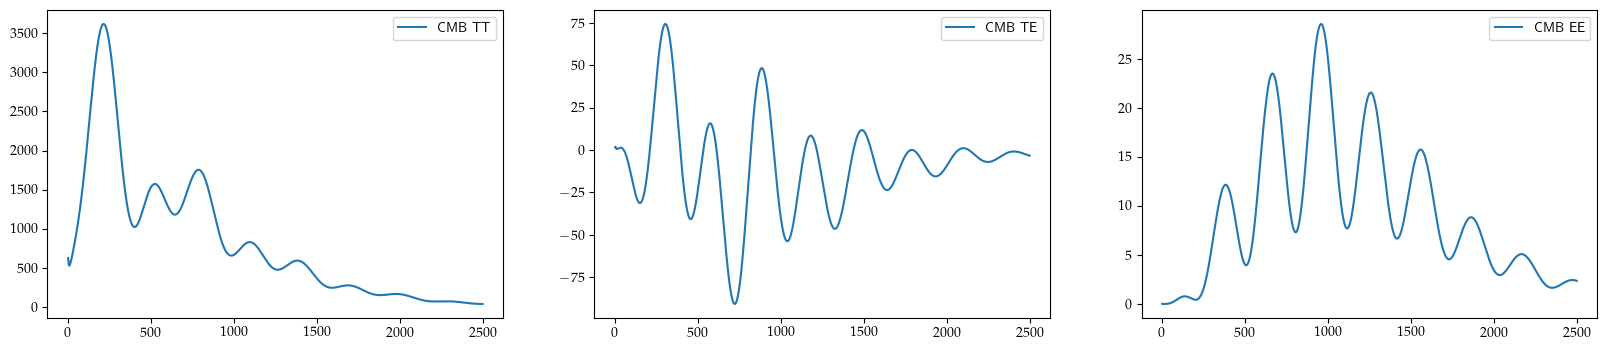

In [10]:
plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.plot(ells, record_tt.iloc[0], label='CMB TT')
plt.legend(loc='best')

plt.subplot(132)
plt.plot(ells, record_te.iloc[0], label='CMB TE')
plt.legend(loc='best')

plt.subplot(133)
plt.plot(ells, record_ee.iloc[0], label='CMB EE')
plt.legend(loc='best')

plt.show()

# PCA Step

In [11]:
class PreprocessingPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=50, epsilon=1e-6, apply_log=False):
        """
        Initializes the preprocessing pipeline.
        Args:
            n_components (int): Number of principal components for PCA.
            epsilon (float): Small regularization constant for prewhitening.
            apply_log (bool): Whether to apply log-transformation to the data.
        """
        self.n_components = n_components
        self.epsilon = epsilon  # Regularization term for prewhitening
        self.apply_log = apply_log  # Option to apply log-transformation

    def fit(self, X, y=None):
        """
        Fit the pipeline: log-transform (optional), scale the data, apply PCA, and prewhiten.
        Args:
            X (np.ndarray): Input data of shape (N, N_c).
        Returns:
            self
        """
        # Step 1: Apply log-transformation (if enabled)
        if self.apply_log:
            self.shift_ = np.abs(np.min(X)) + 1 if np.min(X) <= 0 else 0  # Shift for non-negative log
            X = np.log(X + self.shift_)

        # Step 2: Fit the column-wise scaler
        self.scaler_means_ = np.mean(X, axis=0)
        self.scaler_stds_ = np.std(X, axis=0, ddof=1)
        X_scaled = (X - self.scaler_means_) / self.scaler_stds_

        # Step 3: Fit PCA
        self.pca = PCA(n_components=self.n_components)
        X_reduced = self.pca.fit_transform(X_scaled)

        # Step 4: Fit prewhitening
        cov_matrix = np.cov(X_reduced, rowvar=False)
        cov_matrix += np.eye(cov_matrix.shape[0]) * self.epsilon  # Regularization
        self.L_ = np.linalg.cholesky(cov_matrix)  # Cholesky decomposition
        self.L_inv_ = np.linalg.inv(self.L_)      # Inverse of Cholesky factor

        return self

    def transform(self, X):
        """
        Apply the pipeline: log-transform (optional), scale, reduce dimensions, and prewhiten.
        Args:
            X (np.ndarray): Input data of shape (N, N_c).
        Returns:
            np.ndarray: Prewhitened data of shape (N, n_components).
        """
        # Step 1: Apply log-transformation (if enabled)
        if self.apply_log:
            X = np.log(X + self.shift_)

        # Step 2: Scale the data
        X_scaled = (X - self.scaler_means_) / self.scaler_stds_

        # Step 3: Apply PCA
        X_reduced = self.pca.transform(X_scaled)

        # Step 4: Prewhiten the data
        X_prewhitened = X_reduced @ self.L_inv_.T
        return X_prewhitened

    def inverse_transform(self, X_prewhitened):
        """
        Reconstruct the original data from prewhitened data.
        Args:
            X_prewhitened (np.ndarray): Prewhitened data of shape (N, n_components).
        Returns:
            np.ndarray: Reconstructed data of shape (N, N_c).
        """
        # Step 1: Reverse the prewhitening
        X_reduced = X_prewhitened @ self.L_.T

        # Step 2: Reverse PCA
        X_scaled = self.pca.inverse_transform(X_reduced)

        # Step 3: Reverse scaling
        X_original = X_scaled * self.scaler_stds_ + self.scaler_means_

        # Step 4: Reverse log-transformation (if enabled)
        if self.apply_log:
            X_original = np.exp(X_original) - self.shift_

        return X_original


class JAXPreprocessingPipeline:
    def __init__(self, n_components=50, epsilon=1e-6, apply_log=False):
        """
        Initializes the preprocessing pipeline.
        Args:
            n_components (int): Number of principal components for PCA.
            epsilon (float): Small regularization constant for prewhitening.
            apply_log (bool): Whether to apply log-transformation to the data.
        """
        self.n_components = n_components
        self.epsilon = epsilon  # Regularization for prewhitening
        self.apply_log = apply_log  # Option to apply log-transformation

    def fit(self, X):
        """
        Fit the pipeline: log-transform (optional), scale the data, apply PCA, and prewhiten.
        Args:
            X (jnp.ndarray): Input data of shape (N, N_c).
        Returns:
            self
        """
        # Step 1: Apply log-transformation (if enabled)
        if self.apply_log:
            self.shift_ = jnp.abs(jnp.min(X)) + 1 if jnp.min(X) <= 0 else 0  # Shift for non-negative log
            X = jnp.log(X + self.shift_)

        # Step 2: Compute column-wise means and standard deviations
        self.means_ = jnp.mean(X, axis=0)
        self.stds_ = jnp.std(X, axis=0)
        X_scaled = (X - self.means_) / self.stds_

        # Step 3: Apply PCA using SVD
        U, S, Vt = jnp.linalg.svd(X_scaled, full_matrices=False)
        self.components_ = Vt[:self.n_components]  # Top principal components
        X_reduced = jnp.dot(X_scaled, self.components_.T)

        # Step 4: Compute covariance of reduced data and prewhiten
        cov_matrix = jnp.cov(X_reduced, rowvar=False)
        cov_matrix += jnp.eye(cov_matrix.shape[0]) * self.epsilon  # Regularization
        self.L_ = jnp.linalg.cholesky(cov_matrix)  # Cholesky decomposition
        self.L_inv_ = jnp.linalg.inv(self.L_)      # Inverse of Cholesky factor

        return self

    def transform(self, X):
        """
        Apply the pipeline: log-transform (optional), scale, reduce dimensions, and prewhiten.
        Args:
            X (jnp.ndarray): Input data of shape (N, N_c).
        Returns:
            jnp.ndarray: Prewhitened data of shape (N, n_components).
        """
        # Step 1: Apply log-transformation (if enabled)
        if self.apply_log:
            X = jnp.log(X + self.shift_)

        # Step 2: Scale the data
        X_scaled = (X - self.means_) / self.stds_

        # Step 3: Apply PCA
        X_reduced = jnp.dot(X_scaled, self.components_.T)

        # Step 4: Prewhiten the data
        X_prewhitened = jnp.dot(X_reduced, self.L_inv_.T)
        return X_prewhitened

    def inverse_transform(self, X_prewhitened):
        """
        Reconstruct the original data from prewhitened data.
        Args:
            X_prewhitened (jnp.ndarray): Prewhitened data of shape (N, n_components).
        Returns:
            jnp.ndarray: Reconstructed original data of shape (N, N_c).
        """
        # Step 1: Reverse prewhitening
        X_reduced = jnp.dot(X_prewhitened, self.L_.T)

        # Step 2: Reverse PCA
        X_scaled = jnp.dot(X_reduced, self.components_)

        # Step 3: Reverse scaling
        X_original = X_scaled * self.stds_ + self.means_

        # Step 4: Reverse log-transformation (if enabled)
        if self.apply_log:
            X_original = jnp.exp(X_original) - self.shift_

        return X_original


In [12]:
def train_gps(config: ConfigDict,
              cosmologies: torch.Tensor,
              outputs: torch.Tensor,
              prewhiten: bool,
              ylog: bool,
              fname='cmb_cls_ee') -> List:
    """Train Gaussian Processes (GPs) for the given cosmologies and outputs.

    This function optimizes the kernel parameters for each output dimension and saves the trained GP models.

    Args:
        config (ConfigDict): A configuration dictionary containing emulator settings.
        cosmologies (torch.Tensor): A tensor containing the cosmological parameters.
        outputs (torch.Tensor): A tensor containing the output values for each cosmology.
        prewhiten (bool): If True, prewhiten the data before training.
        ylog (bool): If True, apply a logarithmic transformation to the output values.
        fname (str, optional): The base filename for saving the trained GP models. Defaults to 'pklin'.

    Returns:
        List[GaussianProcess]: A list of trained GaussianProcess models.

    """
    nout = outputs.shape[1]
    record = []
    for i in range(nout):

        # optimise for the kernel parameters
        gpmodule = GaussianProcess(config,
                                   cosmologies,
                                   outputs[:, i],
                                   prewhiten=prewhiten,
                                   ylog=ylog)
        parameters = torch.randn(6)
        opt_params = gpmodule.optimisation(parameters,
                                           niter=config.emu.niter,
                                           lrate=config.emu.lr,
                                           nrestart=config.emu.nrestart)

        # save the gps and quantities
        save_pkl(gpmodule, 'gps', fname + f'_{i}')
        record.append(gpmodule)
    return record

def train_cmb_cls(cfg,
                  cosmologies,
                  fname: str = 'tt',
                  n_components: int = 50,
                  epsilon: float = 1e-6,
                  apply_log: bool = True):
    """Trains Gaussian Processes (GPs) on Cosmic Microwave Background (CMB) power spectra.

    This function reads CMB power spectrum data, applies preprocessing using
    Principal Component Analysis (PCA) with prewhitening, and trains GPs
    to model the relationship between cosmological parameters and preprocessed
    power spectrum components.

    Args:
        cfg: Configuration object containing hyperparameters and settings for GP training.
        cosmologies (pd.DataFrame): DataFrame containing cosmological parameters.
        fname (str, optional): Identifier for the power spectrum type (e.g., 'tt', 'ee', 'te').
            Defaults to 'tt'.
        n_components (int, optional): Number of principal components to retain. Defaults to 50.
        epsilon (float, optional): Small value to stabilize numerical operations. Defaults to 1e-6.
        apply_log (bool, optional): Whether to apply a logarithmic transformation to the data. Defaults to True.

    Returns:
        tuple: A tuple containing:
            - gps: Trained Gaussian Process models.
            - pipeline: Preprocessing pipeline used to transform the data.
    """
    data = pd.read_csv(f'data/cmb_cls_{fname}.csv', index_col = 0)
    ells = np.array(data.columns, dtype=int)

    pipeline = JAXPreprocessingPipeline(n_components=n_components,
                                        epsilon=epsilon,
                                        apply_log=apply_log)
    pipeline.fit(data.values)
    X_prewhitened = pipeline.transform(data.values).__array__()
    inputs = torch.from_numpy(cosmologies.values)
    outputs = torch.from_numpy(X_prewhitened)
    gps = train_gps(cfg,
                        inputs,
                        outputs,
                        prewhiten=True,
                        ylog=False,
                        fname=f'cmb_cls_{fname}')
    gps = None
    save_pkl(pipeline, 'pipeline', f'cmb_cls_{fname}')
    return gps, pipeline

In [13]:
def load_gps_pipeline(fname: str = 'tt'):
    """Loads trained Gaussian Process models and preprocessing pipeline.

    Args:
        fname (str, optional): Identifier for the power spectrum type (e.g., 'tt', 'ee', 'te').
            Defaults to 'tt'.

    Returns:
        tuple: A tuple containing:
            - gps: Trained Gaussian Process models.
            - pipeline: Preprocessing pipeline used to transform the data.
    """
    gps = [load_pkl('gps', f'cmb_cls_{fname}_{i}') for i in range(50)]
    pipeline = load_pkl('pipeline', f'cmb_cls_{fname}')
    return gps, pipeline

In [14]:
# gps_tt, pipeline_tt = train_cmb_cls(cfg, cosmologies, fname='tt')
# gps_te, pipeline_te = train_cmb_cls(cfg, cosmologies, fname='te')
# gps_ee, pipeline_ee = train_cmb_cls(cfg, cosmologies, fname='ee')

# this took 60 minutes for a single optimisation

### Accuracy Calculation

In [15]:
gps_tt, pipeline_tt = load_gps_pipeline(fname='tt')
gps_te, pipeline_te = load_gps_pipeline(fname='te')
gps_ee, pipeline_ee = load_gps_pipeline(fname='ee')

In [16]:
def calc_pred_gt(cfg: ConfigDict, ntest: int, ells: np.ndarray):

    gps_tt, pipeline_tt = load_gps_pipeline(fname='tt')
    gps_te, pipeline_te = load_gps_pipeline(fname='te')
    gps_ee, pipeline_ee = load_gps_pipeline(fname='ee')
    priors = generate_cosmo_priors(cfg)

    df_emu_tt = pd.DataFrame(columns=ells)
    df_emu_te = pd.DataFrame(columns=ells)
    df_emu_ee = pd.DataFrame(columns=ells)
    df_gt_tt = pd.DataFrame(columns=ells)
    df_gt_te = pd.DataFrame(columns=ells)
    df_gt_ee = pd.DataFrame(columns=ells)

    for k in range(ntest):
        testcosmo = np.array([priors[cfg.cosmo.names[i]].rvs().item() for i in range(5)])
        testcosmo_dict = {name: testcosmo[i] for i, name in enumerate(cfg.cosmo.names)}
        cosmo_tensor = torch.tensor(testcosmo).view(-1)

        # do the predictions
        prediction_tt = np.asarray([gps_tt[i].prediction(cosmo_tensor).item() for i in range(50)])
        prediction_te = np.asarray([gps_te[i].prediction(cosmo_tensor).item() for i in range(50)])
        prediction_ee = np.asarray([gps_ee[i].prediction(cosmo_tensor).item() for i in range(50)])
        df_emu_tt.loc[k] = pipeline_tt.inverse_transform(prediction_tt)
        df_emu_te.loc[k] = pipeline_te.inverse_transform(prediction_te)
        df_emu_ee.loc[k] = pipeline_ee.inverse_transform(prediction_ee)

        _, df_gt_tt.loc[k], df_gt_ee.loc[k], df_gt_te.loc[k] = calculate_cmb_cls_class(testcosmo_dict, cfg)

    df_emu_tt.to_csv('data/test_df_emu_tt.csv')
    df_emu_te.to_csv('data/test_df_emu_te.csv')
    df_emu_ee.to_csv('data/test_df_emu_ee.csv')
    df_gt_tt.to_csv('data/test_df_gt_tt.csv')
    df_gt_te.to_csv('data/test_df_gt_te.csv')
    df_gt_ee.to_csv('data/test_df_gt_ee.csv')

    return df_emu_tt, df_emu_te, df_emu_ee, df_gt_tt, df_gt_te, df_gt_ee


In [17]:
# ntest = 1000
# df_emu_tt, df_emu_te, df_emu_ee, df_gt_tt, df_gt_te, df_gt_ee = calc_pred_gt(cfg, ntest, ells)

In [18]:
df_emu_tt = pd.read_csv('data/test_df_emu_tt.csv', index_col=0)
df_emu_te = pd.read_csv('data/test_df_emu_te.csv', index_col=0)
df_emu_ee = pd.read_csv('data/test_df_emu_ee.csv', index_col=0)
df_gt_tt = pd.read_csv('data/test_df_gt_tt.csv', index_col=0)
df_gt_te = pd.read_csv('data/test_df_gt_te.csv', index_col=0)
df_gt_ee = pd.read_csv('data/test_df_gt_ee.csv', index_col=0)


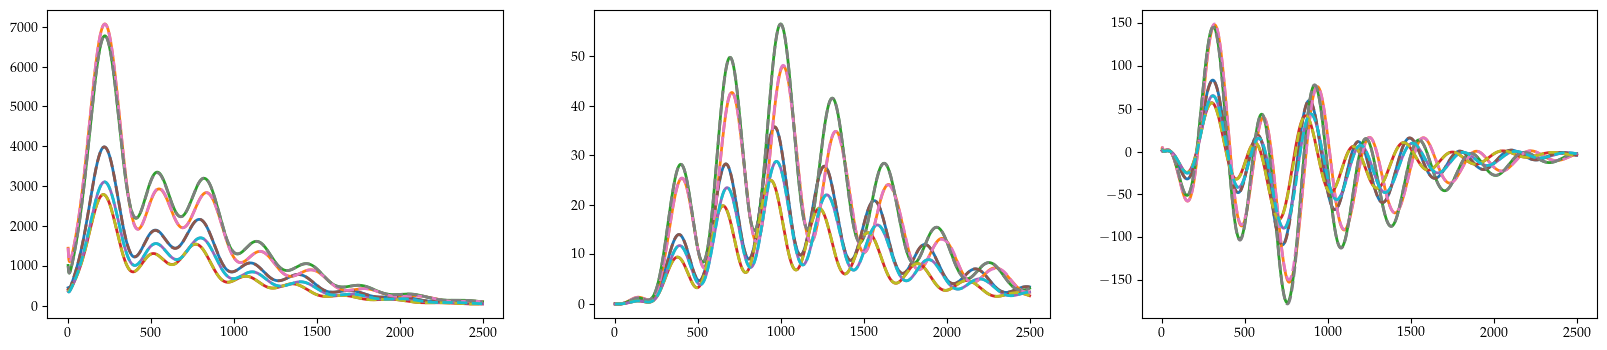

In [19]:
nplot = 5
plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.plot(ells, df_gt_tt.iloc[0:nplot].T, lw=2)
plt.plot(ells, df_emu_tt.iloc[0:nplot].T, linestyle='--', lw=2)

plt.subplot(132)
plt.plot(ells, df_gt_ee.iloc[0:nplot].T, lw=2)
plt.plot(ells, df_emu_ee.iloc[0:nplot].T, linestyle='--', lw=2)

plt.subplot(133)
plt.plot(ells, df_gt_te.iloc[0:nplot].T, lw=2)
plt.plot(ells, df_emu_te.iloc[0:nplot].T, linestyle='--', lw=2)

plt.show()

### Residuals

In [20]:
res_tt = df_gt_tt - df_emu_tt
res_te = df_gt_te - df_emu_te
res_ee = df_gt_ee - df_emu_ee

mean_tt = res_tt.mean()
mean_te = res_te.mean()
mean_ee = res_ee.mean()

std_tt = res_tt.std()
std_te = res_te.std()
std_ee = res_ee.std()

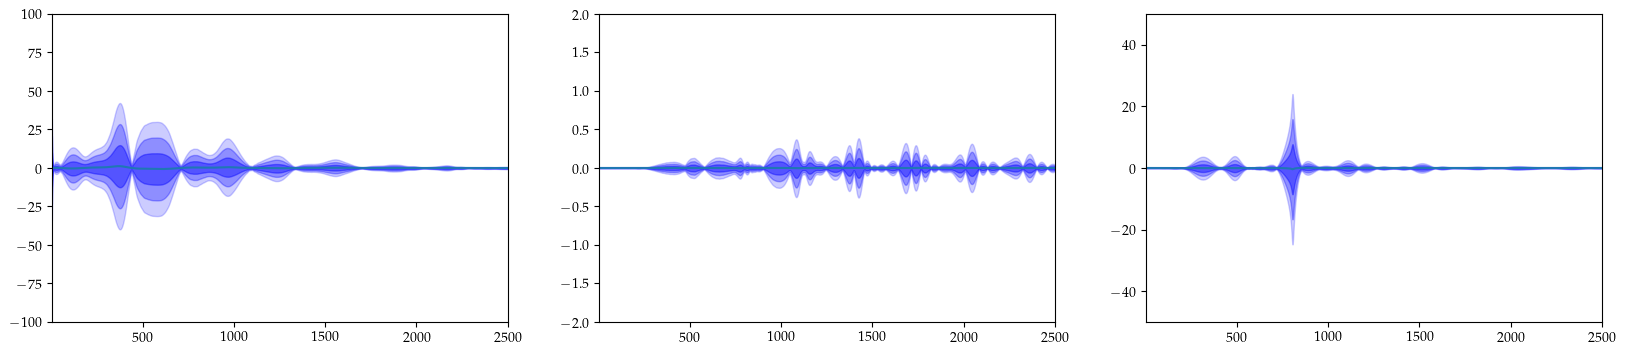

In [21]:
plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.plot(ells, mean_tt.T)
plt.fill_between(ells, mean_tt.T - std_tt.T, mean_tt.T + std_tt.T, color='blue', alpha=0.4)
plt.fill_between(ells, mean_tt.T - 2.0*std_tt.T, mean_tt.T + 2.0*std_tt.T, color='blue', alpha=0.3)
plt.fill_between(ells, mean_tt.T - 3.0*std_tt.T, mean_tt.T + 3.0*std_tt.T, color='blue', alpha=0.2)
plt.xlim(2, 2500)
plt.ylim(-100, 100)


plt.subplot(132)
plt.plot(ells, mean_ee.T)
plt.fill_between(ells, mean_ee.T - std_ee.T, mean_ee.T + std_ee.T, color='blue', alpha=0.4)
plt.fill_between(ells, mean_ee.T - 2.0*std_ee.T, mean_ee.T + 2.0*std_ee.T, color='blue', alpha=0.3)
plt.fill_between(ells, mean_ee.T - 3.0*std_ee.T, mean_ee.T + 3.0*std_ee.T, color='blue', alpha=0.2)
plt.xlim(2, 2500)
plt.ylim(-2, 2)

plt.subplot(133)
plt.plot(ells, mean_te.T)
plt.fill_between(ells, mean_te.T - std_te.T, mean_te.T + std_te.T, color='blue', alpha=0.4)
plt.fill_between(ells, mean_te.T - 2.0*std_te.T, mean_te.T + 2.0*std_te.T, color='blue', alpha=0.3)
plt.fill_between(ells, mean_te.T - 3.0*std_te.T, mean_te.T + 3.0*std_te.T, color='blue', alpha=0.2)
plt.xlim(2, 2500)
plt.ylim(-50, 50)

plt.show()

# Important Quantities

In [22]:
def save_quantities(gps: GaussianProcess, fname: str):
    """Save the quantities of trained Gaussian Process models for use with JAX.

    This function records various quantities from each trained GP model and saves them to a file.

    Args:
        gps (GaussianProcess): A list of trained GaussianProcess models.
        fname (str): The base filename for saving the quantities.

    """
    for i, gpmodule in enumerate(gps):
        # record all quantities to be used for JAX
        quantities = {}
        quantities['hyperparams'] = gpmodule.opt_parameters.data.numpy()
        quantities['cholfactor'] = gpmodule.chol_train.data.numpy()
        quantities['meanparams'] = gpmodule.mean_train.data.numpy()
        quantities['alpha'] = gpmodule.alpha.data.numpy()
        quantities['ystd'] = gpmodule.ystd.data.numpy()
        quantities['ymean'] = gpmodule.ymean.data.numpy()
        quantities['xtrain'] = gpmodule.xtrain.data.numpy()
        save_pkl(quantities, 'jax_cosmo/quantitiesCMB', fname + f'_{i}')

In [23]:
# save_quantities(gps_tt, 'cmb_cls_tt')
# save_quantities(gps_te, 'cmb_cls_te')
# save_quantities(gps_ee, 'cmb_cls_ee')

# JAX-COSMO Implementation

In [24]:
from jax_cosmo.emulator import EMUCMBdata, prediction_cmb_cls

In [ ]:
def compute_cmb_gradients(cosmology: np.ndarray, cfg, eps=1E-2):
    """Computes the first derivative of each CMB power spectrum (TT, EE, TE)
    with respect to each cosmological parameter using finite difference.

    Args:
        cosmology (jnp.ndarray): Array of cosmological parameters.
        cfg: Configuration object containing parameter names and settings.
        eps (float): Finite difference step size.

    Returns:
        jnp.ndarray: A 3D array of shape (num_ells, num_params, 3), where:
            - num_ells is the number of multipoles,
            - num_params is the number of cosmological parameters,
            - The last dimension corresponds to TT, EE, and TE derivatives.
    """
    num_params = len(cfg.cosmo.names)
    num_ells = 2500-1

    # Initialize gradient arrays
    gradients = np.zeros((num_ells, num_params, 3))  # TT, EE, TE derivatives

    # Compute fiducial power spectra
    cosmo_dict = {name: cosmology[i] for i, name in enumerate(cfg.cosmo.names)}
    _, cls_tt_fid, cls_ee_fid, cls_te_fid = calculate_cmb_cls_class(cosmo_dict, cfg)

    for i, name in enumerate(cfg.cosmo.names):
        # Perturb the cosmological parameter
        cosmo_dict_perturbed = cosmo_dict.copy()
        delta = eps * cosmology[i]
        cosmo_dict_perturbed[name] += delta  # Forward step

        # Compute perturbed power spectra
        _, cls_tt_pert, cls_ee_pert, cls_te_pert = calculate_cmb_cls_class(cosmo_dict_perturbed, cfg)

        # Compute finite difference derivative
        gradients[:, i, 0] = (cls_tt_pert - cls_tt_fid) / delta  # dC_ell^TT / dparam
        gradients[:, i, 1] = (cls_ee_pert - cls_ee_fid) / delta  # dC_ell^EE / dparam
        gradients[:, i, 2] = (cls_te_pert - cls_te_fid) / delta  # dC_ell^TE / dparam

    grad = {'tt': gradients[:,:,0], 'ee': gradients[:,:,1], 'te': gradients[:,:,2]}
    return grad

def plot_gradient(gradient: jnp.array, gradient_class: dict, labels: list, emudata: EMUCMBdata, type: str):
    """Plots the gradient of power spectra components.

    Args:
        gradient (jnp.array): A 2D array where each column represents a gradient of a different parameter.
        gradient_class (dict): A dictionary containing gradients computed by CLASS.
        labels (list): A list of labels for the different components of the gradient.
        emudata (EMUCMBdata): An object containing CMB multipoles (ells) used for the x-axis.
        type (str): The type of power spectrum component (e.g., 'TT', 'EE', 'TE').

    Raises:
        ValueError: If the length of `labels` is less than 5 or if `gradient` has fewer than 5 columns.

    """
    plt.figure(figsize=(18, 6))
    for i in range(5):
        plt.subplot(2, 3, i + 1)
        plt.plot(emudata.ells, gradient[:, i], lw=2, label = 'JAX')
        plt.plot(emudata.ells, gradient_class[type][:, i], linestyle='--', lw=2, label = 'CLASS')
        plt.xlabel(r'$\ell$')
        plt.ylabel(labels[i])
        plt.xlim(min(emudata.ells), max(emudata.ells))
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        plt.legend(loc='best')
    plt.show()

In [96]:
emudata = EMUCMBdata()
cosmology = np.array([0.8120, 0.265, 0.04938, 0.6732, 0.96605])

## Mean Prediction

In [97]:
# using the emulator to predict the power spectra
mean_tt_jax = prediction_cmb_cls(cosmology, emudata, 'tt')
mean_te_jax = prediction_cmb_cls(cosmology, emudata, 'te')
mean_ee_jax = prediction_cmb_cls(cosmology, emudata, 'ee')

In [98]:
# using CLASS to predict the power spectra
cosmo_dict = {name: cosmology[i] for i, name in enumerate(cfg.cosmo.names)}
_, cls_tt, cls_ee, cls_te = calculate_cmb_cls_class(cosmo_dict, cfg)

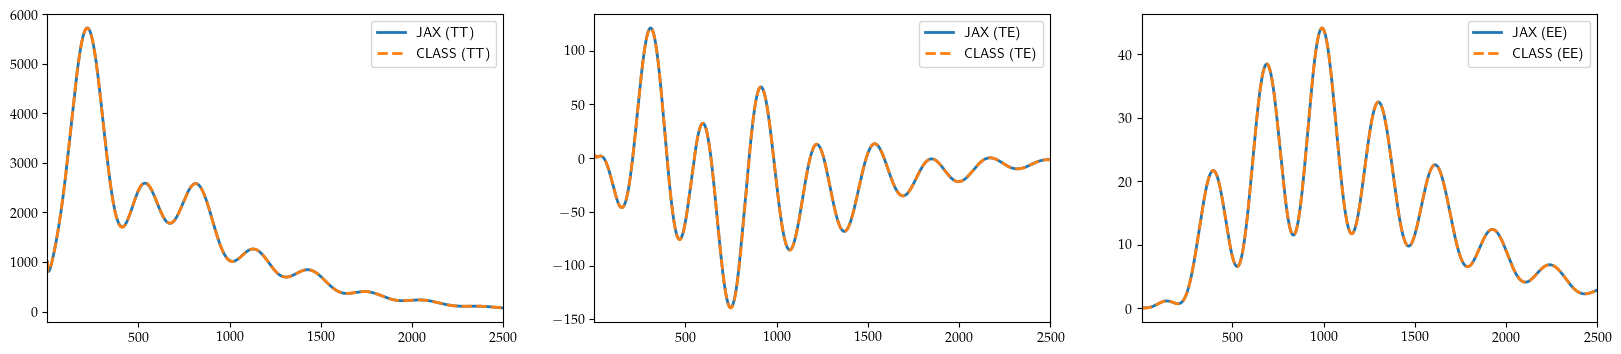

In [99]:
plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.plot(emudata.ells, mean_tt_jax, linestyle = '-', lw=2, label='JAX (TT)')
plt.plot(emudata.ells, cls_tt, linestyle = '--', lw=2, label='CLASS (TT)')
plt.xlim(min(emudata.ells), max(emudata.ells))
plt.legend(loc='best')

plt.subplot(132)
plt.plot(emudata.ells, mean_te_jax, linestyle = '-', lw=2, label='JAX (TE)')
plt.plot(emudata.ells, cls_te, linestyle = '--', lw=2, label='CLASS (TE)')
plt.xlim(min(emudata.ells), max(emudata.ells))
plt.legend(loc='best')

plt.subplot(133)
plt.plot(emudata.ells, mean_ee_jax, linestyle = '-', lw=2, label='JAX (EE)')
plt.plot(emudata.ells, cls_ee, linestyle = '--', lw=2, label='CLASS (EE)')
plt.xlim(min(emudata.ells), max(emudata.ells))
plt.legend(loc='best')

plt.show()

## First Derivative

In [100]:
gradient_tt = jax.jacrev(prediction_cmb_cls)(cosmology, emudata, cls_type='tt')
gradient_te = jax.jacrev(prediction_cmb_cls)(cosmology, emudata, cls_type='te')
gradient_ee = jax.jacrev(prediction_cmb_cls)(cosmology, emudata, cls_type='ee')

In [102]:
gradients_class = compute_cmb_gradients(cosmology, cfg)

In [103]:
labels_grad_tt = [r'$\frac{\partial C_{\ell}^{TT}}{\partial \sigma_{8}}$',
                  r'$\frac{\partial C_{\ell}^{TT}}{\partial \Omega_{c}}$',
                  r'$\frac{\partial C_{\ell}^{TT}}{\partial \Omega_{b}}$',
                  r'$\frac{\partial C_{\ell}^{TT}}{\partial h}$',
                  r'$\frac{\partial C_{\ell}^{TT}}{\partial n_{s}}$',
                  ]

labels_grad_te = [r'$\frac{\partial C_{\ell}^{TE}}{\partial \sigma_{8}}$',
                  r'$\frac{\partial C_{\ell}^{TE}}{\partial \Omega_{c}}$',
                  r'$\frac{\partial C_{\ell}^{TE}}{\partial \Omega_{b}}$',
                  r'$\frac{\partial C_{\ell}^{TE}}{\partial h}$',
                  r'$\frac{\partial C_{\ell}^{TE}}{\partial n_{s}}$',
                  ]

labels_grad_ee = [r'$\frac{\partial C_{\ell}^{EE}}{\partial \sigma_{8}}$',
                  r'$\frac{\partial C_{\ell}^{EE}}{\partial \Omega_{c}}$',
                  r'$\frac{\partial C_{\ell}^{EE}}{\partial \Omega_{b}}$',
                  r'$\frac{\partial C_{\ell}^{EE}}{\partial h}$',
                  r'$\frac{\partial C_{\ell}^{EE}}{\partial n_{s}}$',
                  ]


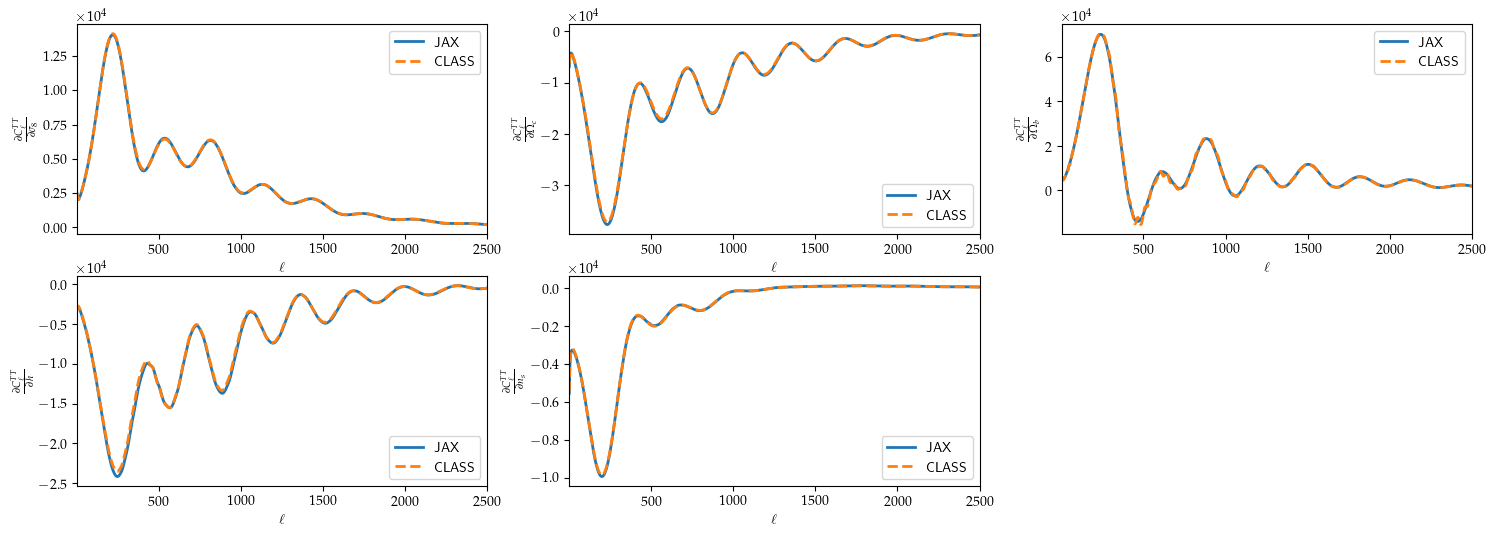

In [104]:
plot_gradient(gradient_tt, gradients_class, labels_grad_tt, emudata, 'tt')